__Plotting script comparing the TCR for SimMod and the observation-based ensemble.__

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import os
from scipy import interpolate
%matplotlib inline
plt.rcParams['font.size'] = 15

In [4]:
obs_temp_path = "../data/preprocessed/Observations_TAnom.csv"
simmod_path = "../data/preprocessed/SimMod_timeseries.csv"
forcing_path = "../data/preprocessed/forcing_ensemble_base1961-1990.npy"

observations = pd.read_csv(obs_temp_path, skiprows=10)
simmod = pd.read_csv(simmod_path)
forcings = np.load(forcing_path, allow_pickle=True).item()

In [5]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Blues')
new_cmap = truncate_colormap(cmap, 0., 0.9)
new_cmap.set_bad(color = 'w', alpha = 1.)

/home/jeremias/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice
/home/jeremias/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


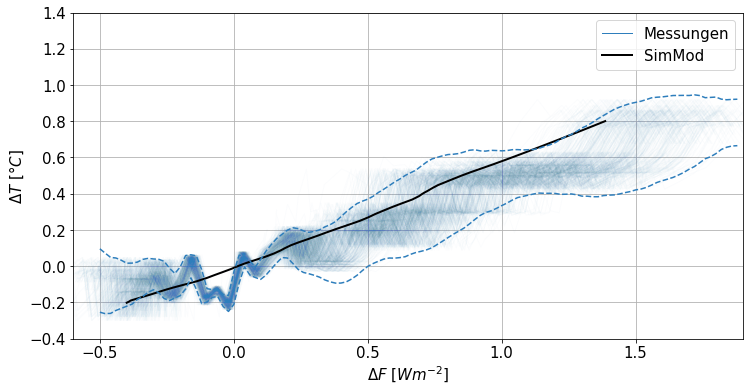

In [8]:
plt.subplots(figsize=(12,6))

df=0.02
env_f = np.arange(-1.0, 2.5, df)
env_t = np.zeros((env_f.size, 1000))
forcing_itp = np.arange(-0.5, 2.2, df/10.)

obs_names = ['hadcrut4', 'gistemp', 'noaa', 'berkeley', 'cowtan_way']
obs_years = observations['year']

#timeframe = (max([obs_years.min(), forcings['year'].min()]),
#             min([obs_years.max(), forcings['year'].max()]))
timeframe = (1960, 2017)

time_mask_obs = (obs_years >= timeframe[0]) & (obs_years <= timeframe[1])
time_mask_forcing = (forcings['year'] >= timeframe[0]) & (forcings['year'] <= timeframe[1])
time_mask_simmod = (simmod['year'] >= timeframe[0]) & (simmod['year'] <= timeframe[1])

for obs in obs_names:
    obs_temps = observations[obs][time_mask_obs]
    
    plot_indices = np.random.randint(low=0, high=1000, size=100)
    for forcing_num in range(1000):
        forcing = forcings['rf_anthro'][time_mask_forcing,forcing_num]
        
        itp = interpolate.interp1d(forcing, obs_temps, fill_value=np.nan, bounds_error=False)
        temp_itp = itp(forcing_itp)
        
        # find envelope
        for f_idx in range(0, env_f.size):
            gt_mask = (forcing_itp >= env_f[f_idx] - df/2.)
            lt_mask = (forcing_itp <= env_f[f_idx] + df/2.)
            mask = gt_mask & lt_mask
            if np.any(mask):
                env_t[f_idx, forcing_num] = np.mean(temp_itp[mask])
            else:
                env_t[f_idx, forcing_num] = np.nan
   
        if forcing_num in plot_indices:
            plt.plot(forcing, obs_temps, color=cmap(0.7), alpha=0.015, lw=1.0)

# Just for the legend
plt.plot([-999, -999], [-999, -998], color=cmap(0.7), lw=1.0, label='Messungen')
        
env_t_mean = np.nanmean(env_t,axis=1)
env_t_std = np.nanstd(env_t,axis=1)
env_t_upper = env_t_mean+1.96*env_t_std
env_t_lower = env_t_mean-1.96*env_t_std

small_sample_mask = ((~np.isnan(env_t)).sum(axis=1) < 50)
env_t_upper[small_sample_mask] = np.nan
env_t_lower[small_sample_mask] = np.nan

#plt.plot(simmod['SimMod2.6_f'][time_mask_simmod], simmod['SimMod2.6_t'][time_mask_simmod], c='k', lw=2)
plt.plot(simmod['SimMod4.5_f'][time_mask_simmod], simmod['SimMod4.5_t'][time_mask_simmod], c='k', lw=2,
         label='SimMod')
#plt.plot(simmod['SimMod6.0_f'][time_mask_simmod], simmod['SimMod6.0_t'][time_mask_simmod], c='k', lw=2)
#plt.plot(simmod['SimMod8.5_f'][time_mask_simmod], simmod['SimMod8.5_t'][time_mask_simmod], c='k', lw=2)

plt.plot(env_f,env_t_upper,color=cmap(0.7),lw=1.5, linestyle='--')
plt.plot(env_f,env_t_lower,color=cmap(0.7),lw=1.5, linestyle='--')

plt.xlabel(r"$\Delta F$ $[Wm^{-2}]$")
plt.ylabel(r"$\Delta T$ $[\degree C]$")
#plt.ylim([-0.8,1.4])
#plt.xlim([-1.5,2.2])
plt.ylim([-0.4,1.4])
plt.xlim([-0.6,1.9])
plt.grid()
plt.legend()

#plt.savefig("figures/temp_forcing_SimMod.pdf", bbox_inches="tight")
plt.show()

In [7]:
print(f"Zeitraum: Jan {int(timeframe[0])} - Dec {int(timeframe[1])}")

Zeitraum: Jan 1960 - Dec 2017
